In [ ]:
import os
import string
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K
import glob
import shutil

import tensorflow as tf

import utils
reload(utils)

%matplotlib inline

# the plan:
- assume data is already set up from sketchnet1 nb
- build network based on deepsketch2 convnet
- test on sample, then train using a script



In [ ]:
batch_size = 10

data_root = '../data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

img_height = 224
img_width = 224

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        rotation_range=35,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
# img_height = batch.shape[1]
# img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

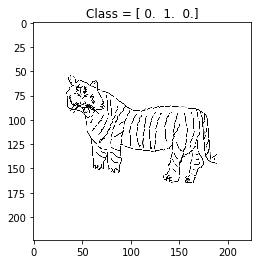

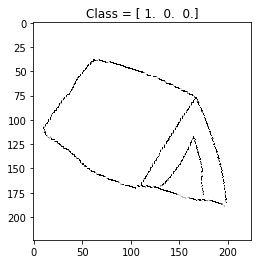

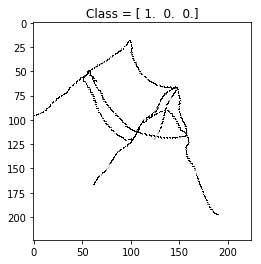

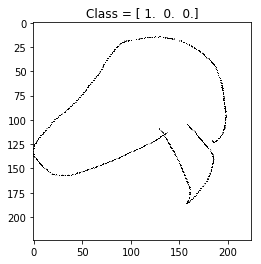

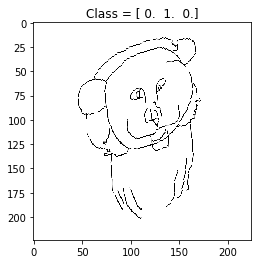

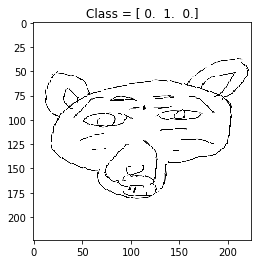

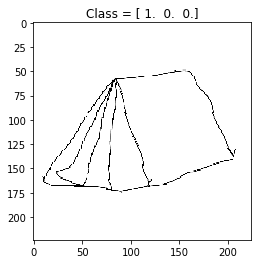

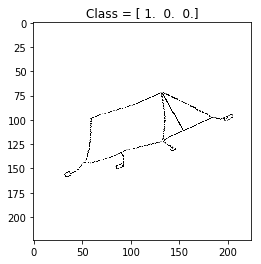

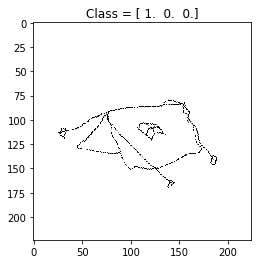

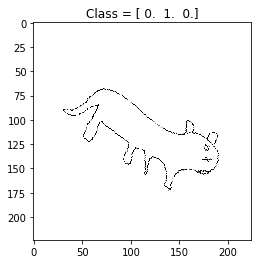

In [14]:
X_batch, y_batch = train_generator.next()
for i in range(y_batch.shape[0]):
    utils.show_sample(X_batch[i], y_batch[i])

In [ ]:
model_name = 'deepsketch2'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

log_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
best_model_callback =\
    ModelCheckpoint('./models/'+model_name+'/best.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)
latest_model_callback =\
    ModelCheckpoint('./models/'+model_name+'/latest.h5', 
                    verbose=0, 
                    save_weights_only=True, 
                     period=1)
lr_cb = \
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                  patience=5, min_lr=0.0001)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Convolution2D(64, (7, 7), 
                            padding='same',
                            strides=(2,2),
                            input_shape=(img_width, img_height, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(2,2)))

    model.add(Convolution2D(128, (5, 5), 
                            strides=(2,2),
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(2,2)))

    model.add(Convolution2D(256, (3, 3),
                            strides=(2,2),
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(2,2)))
    
    model.add(Convolution2D(512, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initialize optimizer
    opt = optimizers.rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model, opt

# tf.reset_default_graph()
model1, opt1 = build_model()
model1.summary()

In [ ]:
total_epochs = 0

In [ ]:
nb_epoch = 1
K.set_value(opt1.lr, 0.0001)

hist = model1.fit_generator(
        train_generator,
        steps_per_epoch = 18,
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_callback, 
                   best_model_callback,
                   latest_model_callback]
)
total_epochs += nb_epoch

In [12]:
3*60*60/6

1800

In [9]:
nb_epoch = 20
K.set_value(opt1.lr, 0.0005)

hist = model1.fit_generator(
        train_generator,
        steps_per_epoch = 18,
        epochs = nb_epoch+total_epochs,
        validation_data = validation_generator,
        validation_steps = 6,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_callback, 
                   best_model_callback,
                   latest_model_callback,
                   lr_cb]
)
total_epochs += nb_epoch

Epoch 22/41
18/18 [==============================] - 1s - loss: 1.0986 - acc: 0.3413 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 23/41
18/18 [==============================] - 0s - loss: 1.0990 - acc: 0.2957 - val_loss: 1.0989 - val_acc: 0.3137
Epoch 24/41
18/18 [==============================] - 1s - loss: 1.0985 - acc: 0.3593 - val_loss: 1.0989 - val_acc: 0.3167
Epoch 25/41
18/18 [==============================] - 1s - loss: 1.0988 - acc: 0.3302 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 26/41
18/18 [==============================] - 1s - loss: 1.0986 - acc: 0.3568 - val_loss: 1.0977 - val_acc: 0.4314
Epoch 27/41
18/18 [==============================] - 1s - loss: 1.0994 - acc: 0.3013 - val_loss: 1.0996 - val_acc: 0.2353
Epoch 28/41
18/18 [==============================] - 1s - loss: 1.0991 - acc: 0.3296 - val_loss: 1.0978 - val_acc: 0.4118
Epoch 29/41
18/18 [==============================] - 1s - loss: 1.0979 - acc: 0.3957 - val_loss: 1.0987 - val_acc: 0.3500
Epoch 30/41
18/18 [=====

utils.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if prediction != None:


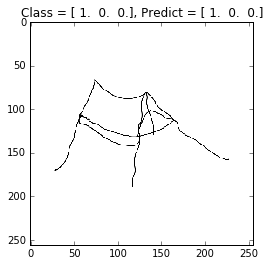

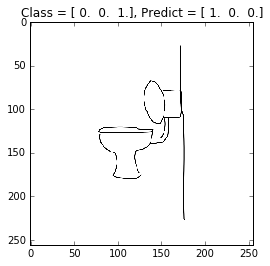

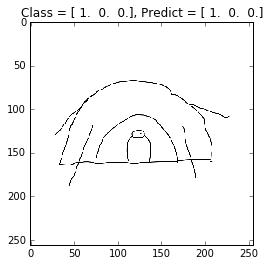

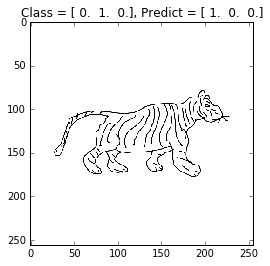

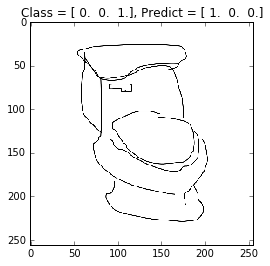

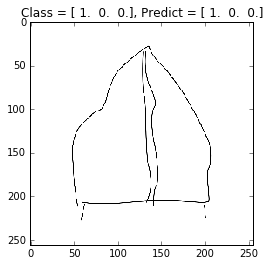

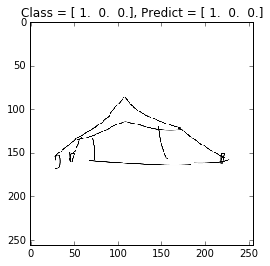

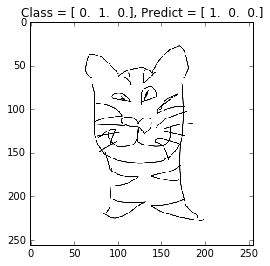

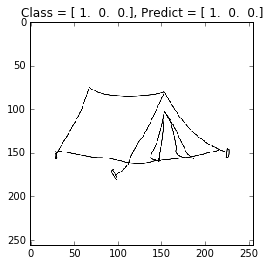

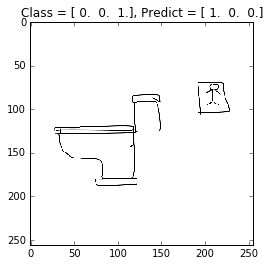

In [28]:
# load model and display some predictions
X_batch, y_batch = validation_generator.next()
y_pred = model1.predict(X_batch)
for i in range(y_batch.shape[0]):
    utils.show_sample(X_batch[i], y_batch[i], y_pred[i])